In [1]:
from notebooks.tools import load_dataset
import torch

%load_ext autoreload
%autoreload 2

In [2]:
DATASET_12_LIST = ('handbag', '/home/nazar/projects/handbag_64.hdf5', 
                    'shoes', '/home/nazar/projects/shoes_64.hdf5', 64)

In [3]:
from typing import Iterator, Literal, NamedTuple, Optional, Tuple
import dataclasses
import jax
from jax import numpy as jnp

class Dataset(NamedTuple):
  source_iter: Iterator[jnp.ndarray]
  target_iter: Iterator[jnp.ndarray]


@dataclasses.dataclass
class ImagesSampler:
    def __init__(self, size, name, path, img_size = 64):
        self.sampler, _ = load_dataset(name, path, img_size=img_size, batch_size=size, device="cpu")
        self.size = size
        self.img_size = img_size
        
    def __iter__(self):
        rng = jax.random.PRNGKey(0)
        while True:
            rng, sample_key = jax.random.split(rng, 2)
            yield self._sample(sample_key, self.size)
            
    def _sample(self, key, batch_size):
        return jnp.asarray(self.sampler.sample(batch_size).numpy()).reshape(batch_size, 3 * self.img_size * self.img_size)

In [8]:
from ott.datasets import Dataset
import jax

train_loader = Dataset(
    source_iter=iter(ImagesSampler(128, DATASET_12_LIST[0], DATASET_12_LIST[1])),
    target_iter=iter(ImagesSampler(128, DATASET_12_LIST[2], DATASET_12_LIST[3]))
)
valid_loader = train_loader

Keys: <KeysViewHDF5 ['imgs']>
Keys: <KeysViewHDF5 ['imgs']>


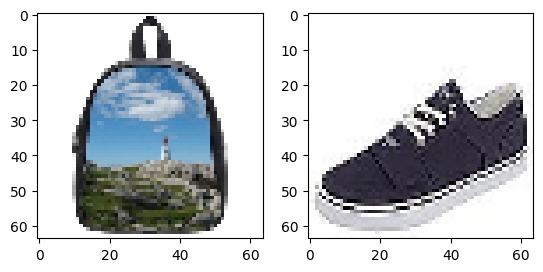

In [9]:
eval_data_source = next(valid_loader.source_iter)
eval_data_target = next(valid_loader.target_iter)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

def to_img(x):
    x = x.reshape(-1, 3, 64, 64).transpose(0, 2, 3, 1)
    x = (x * 0.5 + 0.5).clip(0., 1.)
    return x

ax[0].imshow(to_img(eval_data_source[0])[0])
ax[1].imshow(to_img(eval_data_target[0])[0])

In [10]:
from IPython.display import clear_output, display

def training_callback(step, learned_potentials):
    if step % 500 == 10:
        # clear_output()
        print(f"Training iteration: {step}")
        neural_dual_dist = learned_potentials.distance(
            eval_data_source, eval_data_target
        )
        print(
            f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
        )
        pred = learned_potentials.transport(eval_data_source)

        fig, ax = plt.subplots(3, 2)

        ax[0, 0].imshow(to_img(eval_data_source[0])[0])
        ax[0, 1].imshow(to_img(pred[0])[0])

        ax[1, 0].imshow(to_img(eval_data_source[1])[0])
        ax[1, 1].imshow(to_img(pred[1])[0])

        ax[2, 0].imshow(to_img(eval_data_source[2])[0])
        ax[2, 1].imshow(to_img(pred[2])[0])

        display(fig)
        plt.close(fig)


  0%|          | 0/200000 [00:00<?, ?it/s]

Training iteration: 10
Neural dual distance between source and target data: 800.10


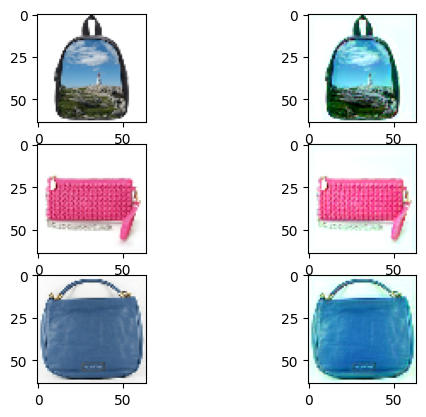

Training iteration: 510
Neural dual distance between source and target data: 2244.81


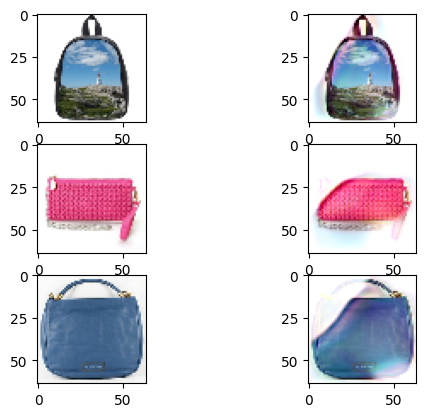

Training iteration: 1010
Neural dual distance between source and target data: 4345.18


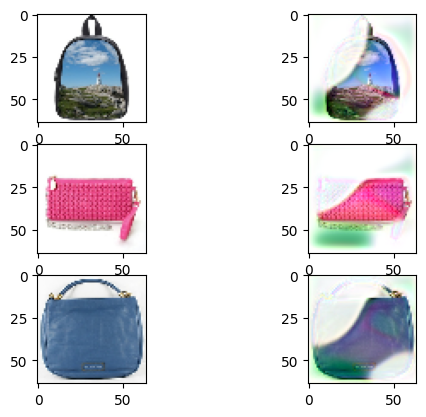

KeyboardInterrupt: 

In [11]:
from ott.neural.methods.expectile_neural_dual import ExpectileNeuralDual
from ott.geometry import costs
from notebooks.resnet import ResNet_D
from notebooks.unet import UNet2, UNet
import optax
import jax

neural_f = UNet(3, 3, 64)
# neural_f = ResNet_D(64, nfilter=32, nlayers=4)
neural_g = ResNet_D(64, nfilter=64, nlayers=4)

num_train_iters = 200_000

lr_schedule_f = optax.cosine_decay_schedule(
    init_value=1e-4, decay_steps=num_train_iters, alpha=1e-4
)

lr_schedule_g = optax.cosine_decay_schedule(
    init_value=1e-4, decay_steps=num_train_iters, alpha=1e-4
)
optimizer_f = optax.adam(learning_rate=lr_schedule_f, b1=0.9, b2=0.99)
optimizer_g = optax.adam(learning_rate=lr_schedule_g, b1=0.9, b2=0.99)

neural_dual_solver = ExpectileNeuralDual(
    3 * 64 * 64,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    cost_fn=costs.SqEuclidean(),
    num_train_iters=num_train_iters,
    expectile=0.99,
    expectile_loss_coef=0.5,
    rng=jax.random.PRNGKey(5),
    is_bidirectional=False,
    # use_dot_product=True
)
learned_potentials = neural_dual_solver(
    *train_loader,
    *valid_loader,
    callback=training_callback
)